# Fundamentals of Social Data Science 2025 Week 3 Group Project

Instructions: 

Two questions for the presentation:
1. What can we learn about social data science from a merged network of all the different responses?
2. What can we learn from individual networks that is not apparent from the merged response?
For example:
- "Alice discovered that only one network linked 'community' and 'class' ".
- "Bob discovered that networks which mentioned 'community' were the densest".

You only need to submit a group presentation and the code. However! This time around, each person in the group must put their name to a specific claim for question 2. Only person will deliver the presentation. 

## Import and merge network data - taken from instructor example answer

In [1]:
# Part 1. Merging Ego and Alter Networks
 
import networkx as nx 
import pandas as pd 
from pathlib import Path

# Set the path to our files. For me it is under this folder in 
# "Network Canvas Export Tables"
file_path = Path('../data/network_data')
file_list = file_path.glob(file_path / "*attributeList_concept.csv")

# The trickiest part is managing the linking key which comes from the file name
concept_files = [] 
for i in file_path.glob("*attributeList_concept.csv"):
    df_temp = pd.read_csv(i)
    session_id = i.name.split("_")[1]
    df_temp["session_id"] = session_id
    concept_files.append(df_temp)

# Concatenate all the alter files, then reset the index
df_alters = pd.concat(concept_files)
df_alters.reset_index()

# Now we explore the ego_files: 
# We can merge these directly where df_alter["session_id"] == ["networkCanvasSessionID"]
ego_files = []
for i in file_path.glob("*_ego.csv"):
    ego_files.append( pd.read_csv(i))

df_ego = pd.concat(ego_files)

df_alters = df_alters.merge(df_ego, left_on="session_id", right_on="networkCanvasSessionID")

# For a brief report, we can check the value_counts of the name variable
df_alters["name"].value_counts()

name
AI                 15
technology         11
empirical data     10
ethics             10
analysis           10
knowledge           9
community           8
context             8
theory              8
social networks     7
change              7
optimisation        6
perspective         6
truth               6
inequality          5
identity            5
macro-micro         5
culture             5
structure           5
policy              4
progress            4
development         4
power               4
social norms        3
user experience     2
race-ethnicity      2
design              2
justice             2
privacy             2
class               2
collective          2
gender              1
personal            1
freedom             1
music               1
art                 1
history             1
individual          1
Name: count, dtype: int64

In [2]:
# Part 2. Merging in Giant Component data
# This is considerably more challenging overall. 

# To attempt this, I first build a dictionary {"sessionID":file_path}
# I do this so later we know which path to merge with which session data.
edge_list = []
for i in file_path.glob("*ego.csv"):
    x = i.name.split("_")[:-1]
    x.append("edgeList_relate.csv")
    edge_path = Path(file_path / "_".join(x))
    key = i.name.split("_")[1]
    
    if edge_path.exists():
        edge_list.append(
            {"key":key,
             "path":edge_path
             })
    else:
        raise Exception("Warning: The edge path file does not exist.") 

# Now we can iterate through the paths. 
# For each path we create a network. I did this by:
# reading the CSV to a DataFrame
# taking the source and target columns as lists
# zipping the list: this way instead of [1,2,3,4], [a,b,c,d] we have [(1,a), (2,b), (3,c), (4,d)]
# a zip object is a 'generator' but we need it as list, so its list(zip(l1,l2))

edgelist_dfs = []
for edge_file in edge_list:
    edge_df = pd.read_csv(edge_file["path"])
    edges = zip(edge_df["networkCanvasSourceUUID"].to_list(),edge_df["networkCanvasTargetUUID"].to_list())
    edges = list(edges)
    G = nx.Graph(edges)
        
    # Once we have the zipped list, these are the edges. We can then check the giant component.
    ccs = sorted(list(nx.connected_components(G)), key=len, reverse=True)

    # Sort components to check if same length
    giant_component = ccs[0]
    if len(ccs) > 1:
        for i in ccs[1:]:
            if len(i) == len(ccs[0]):
                giant_component.extend(i)

    # Now we create a temporary dataframe with two columns: 
    # networkCanvasUUID (which is the ID of the concept)
    # networkCanvasSessionID (which is the joining key)
    df_temp = pd.DataFrame(giant_component, columns=["networkCanvasUUID"])
    df_temp["networkCanvasSessionID"] = edge_file["key"]
    # And we add "in_gcc" = 1, later we populate all the rest as 0
    df_temp["in_gcc"] = 1
    edgelist_dfs.append(df_temp)

# We concatenate all the components into a single DataFrame
# And then we use (and this is tricky as it was not mentioned in the lecture: )
df_edgelist_gcc = pd.concat(edgelist_dfs) 
df_alters = df_alters.merge(df_edgelist_gcc, on=["networkCanvasSessionID","networkCanvasUUID"], how="left")

# Where we didn't get a value from the merge, that node was not in the giant component for that ego
df_alters.fillna({"in_gcc":0}, inplace = True)

df_alters["in_gcc"].value_counts()

in_gcc
1.0    147
0.0     39
Name: count, dtype: int64

# Q2. Aggregating networks

Now with your `df_alter` DataFrame table, aggregate over the concepts to produce `df_concepts`, counting:
  - the number of times they appear 
  - the number of times they appear in the giant component

Q2.1: Descriptive questions: 
- How many concepts appear in total? 
- Which concept appears the most? Please produce a table ranking the concepts from most to least common. 

# Q2 Answer below here 

Please use markdown or python cells as necessary. 

In [3]:
# We filter first to the columns of interest: name and 'in_gcc'
# Then we groupby and get a count of these as well as a sum.
# Count will get us how many times the concept appeared; 
# Sum will get us how many times it appeared in the giant component.
df_concepts = df_alters[["name","in_gcc"]].groupby("name").agg(["count","sum"])
df_concepts.columns = ["concept_count", "concept_sum"]
df_concepts.sort_values("concept_count",ascending=False,inplace=True)
df_concepts

,concept_count,concept_sum
name,,
AI,15,12.0
technology,11,10.0
ethics,10,8.0
empirical data,10,9.0
analysis,10,9.0
knowledge,9,7.0
context,8,7.0
community,8,6.0
theory,8,7.0


# Q3. **Optional challenge questions: Distance metrics** 

This is optional as we have not yet gone through the measures of this, but for the intrepid student, you may want to do this on your own. We will cover these measures next week. 

## Q3.1. Euclidean distance.

Take the xy coordinates for each concept in the alter table. Calculate the distance from the center (should be [0.5, 0.5]). 
- For each concept in the alter_table: What is the distance from the center?
- For each concept in the concept_table: What is the mean distance from the center? What is the standard deviation?

Present a table with the $\approx 30$ concepts from least average distance to most average distance from the center.  

## Q3.2 Cosine similarity 

Calculate the angle around the circle. This should be in the form of a cosine rather than degree (e.g., 360 degrees). This would be per-ego. 

- For each concept in the alter_table: find the concept that is closest to this concept per network. Then merge this into the `df_concept` table such that the we know the concept that is most common as the closest to this concept. 
- For example, if on one network there is `identity` and the closest concept is `social networks` in one network, but `community` in three networks, then the `most_common_similar_concept` would be community. 
- For each concept in the `df_concept`: report the most common closest concept for each of the concepts in the network in a table. 




# Q3. answer below here

Please use markdown or python cells as necessary. 

,mentions,distance
name,,
design,2,0.081255
freedom,1,0.085239
history,1,0.103096
individual,1,0.107629
personal,1,0.109637
empirical data,10,0.111360
truth,6,0.129760
collective,2,0.131093
community,8,0.134687


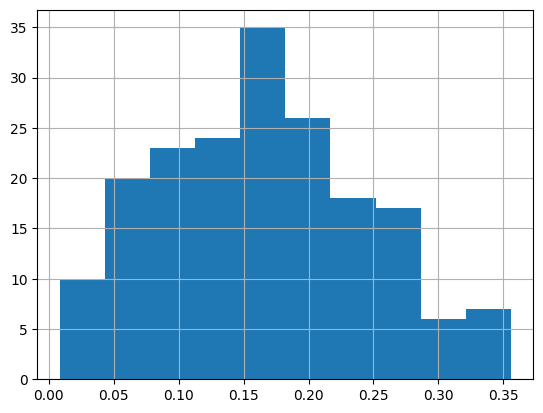

In [4]:
import numpy as np
# distance = np.linalg.norm([x - 0.5, y - 0.5])
# apply for rows rather than columns is axis=1
df_alters['distance'] = df_alters.apply(lambda row: np.linalg.norm([row['user_layout_x'] - 0.5, row['user_layout_y'] - 0.5]), axis=1)
df_alters["distance"].hist()

df_concepts_2 = df_alters[["name","distance"]].groupby("name").agg(["count","mean"])
df_concepts_2.columns = ["mentions","distance"]

# Sort the concepts so that least distance is on top.
df_concepts_2.sort_values("distance",inplace=True)
df_concepts_2

From the above analysis we can see that a few terms that were not mentioned often tended to be at the same time, the concepts most close to a given person. Thus when we look at the most common concepts, such as AI and ethics, these might not be the most important concepts for someone but a sort of key common concept. 

By visualising the distance as a histogram we can see that most of the nodes were around ring 2 or 3 (assuming that sqrt(2), being right in the corner, is the max distance, but rarely used).

In [5]:
# Note that in this section, ClaudeAI was used to calculate the cosine distance in radians.
# Code was integrated and edited 

import numpy as np
import pandas as pd

# This is because 330 and 30 degrees is really 60, not 300 degrees apart.
def angular_distance(angle1, angle2):
    """Calculate smallest angular distance between two angles (in radians)"""
    diff = np.abs(angle1 - angle2)
    return np.minimum(diff, 2*np.pi - diff)

# We are getting the angles within each egonet using 'group' (here 'group' is just a label)
def find_nearest_node_in_egonet(group):
    """Helper function to find nearest angle within a group"""
    angles = group['angle_rad'].values
    indices = group.index.values
    n = len(angles)
    
    # Just a sense check in case of a network with a single node
    if n <= 1:
        return pd.Series([None] * n, index=indices)
    
    # Create angular distance matrix
    # Notice the terms [:, None] and [None, :]
    angle_diff = np.abs(angles[:, None] - angles[None, :])
    angular_dist = np.minimum(angle_diff, 2*np.pi - angle_diff)
    
    # Set diagonal to infinity (default 0 would mean every term closest to itself)
    np.fill_diagonal(angular_dist, np.inf)
    
    # Get nearest index for each row
    # argmin means the minimum score within some vector
    nearest_positions = np.argmin(angular_dist, axis=1)
    nearest_indices = indices[nearest_positions]
    
    return pd.Series(nearest_indices, index=indices)

def find_nearest_node(df, category):
    """Vectorized version using groupby"""
    
    # Include groups is just for a future warning; we don't pass group structure, its unnecessary
    nearest_node = (df
                    .groupby(category, group_keys=False)
                    .apply(find_nearest_node_in_egonet,include_groups=False))
    return nearest_node.map(df_alters['name'])

# We first calculate the angle in radians for all alters independently. 
df_alters['angle_rad'] = np.arctan2(df_alters['user_layout_x'] - 0.5, df_alters['user_layout_y'] - 0.5)

# To get the nearest angle, we pass the DF as well as the grouping parameter
df_alters['nearest_angle_node'] = find_nearest_node(df_alters,"session_id")

# Now we create another concept network. 
df_concepts_3 = df_alters[["name","nearest_angle_node"]].groupby("name").agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# We can concatenate these using axis=1 since we had the same idx (the concept name) for all our tables.
merged_df = pd.concat([df_concepts, df_concepts_2, df_concepts_3],axis=1)
merged_df


,concept_count,concept_sum,mentions,distance,nearest_angle_node
name,,,,,
AI,15,12.0,15,0.135176,ethics
technology,11,10.0,11,0.144910,development
ethics,10,8.0,10,0.148323,AI
empirical data,10,9.0,10,0.111360,technology
analysis,10,9.0,10,0.144818,empirical data
knowledge,9,7.0,9,0.154507,AI
context,8,7.0,8,0.136123,AI
community,8,6.0,8,0.134687,identity
theory,8,7.0,8,0.157885,AI


In [6]:
# clean up a bit 
merged_df.rename(columns={"concept_count":"total_mentions",
                          "concept_sum":"in_gcc_mentions",
                          "distance": "distance_from_center"}, inplace=True)
merged_df.drop(columns=["mentions"], inplace=True)
merged_df

,total_mentions,in_gcc_mentions,distance_from_center,nearest_angle_node
name,,,,
AI,15,12.0,0.135176,ethics
technology,11,10.0,0.144910,development
ethics,10,8.0,0.148323,AI
empirical data,10,9.0,0.111360,technology
analysis,10,9.0,0.144818,empirical data
knowledge,9,7.0,0.154507,AI
context,8,7.0,0.136123,AI
community,8,6.0,0.134687,identity
theory,8,7.0,0.157885,AI


## Sophie Section

In [7]:
import matplotlib.pyplot as plt
import os 
import glob 

### Plot all individual networks 

In [ ]:
# Get unique session IDs
session_ids = df_alters['session_id'].unique()

# Calculate grid dimensions
n_sessions = len(session_ids)
n_cols = 4
n_rows = (n_sessions + n_cols - 1) // n_cols

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Plot each individual network
for idx, session in enumerate(session_ids):
    ax = axes[idx]
    
    # Filter data for this session
    session_data = df_alters[df_alters['session_id'] == session]
    
    # Get the secret word for the title
    secret_word = session_data['secret_word'].iloc[0]
    
    # Plot nodes
    ax.scatter(session_data['user_layout_x'], 
              session_data['user_layout_y'], 
              s=100, alpha=0.6)
    
    # Add labels for each concept
    for _, row in session_data.iterrows():
        ax.annotate(row['name'], 
                   (row['user_layout_x'], row['user_layout_y']),
                   fontsize=8, ha='center')
    
    # Try to plot edges if available
    try:
        # Find the corresponding edge file
        edge_file_path = None
        for edge_info in edge_list:
            if edge_info['key'] == session:
                edge_file_path = edge_info['path']
                break
        
        if edge_file_path and edge_file_path.exists():
            edge_df = pd.read_csv(edge_file_path)
            
            # Create mapping from UUID to coordinates
            uuid_to_coords = dict(zip(session_data['networkCanvasUUID'], 
                                     zip(session_data['user_layout_x'], 
                                         session_data['user_layout_y'])))
            
            # Draw edges
            for _, edge in edge_df.iterrows():
                source_uuid = edge['networkCanvasSourceUUID']
                target_uuid = edge['networkCanvasTargetUUID']
                
                if source_uuid in uuid_to_coords and target_uuid in uuid_to_coords:
                    x_coords = [uuid_to_coords[source_uuid][0], uuid_to_coords[target_uuid][0]]
                    y_coords = [uuid_to_coords[source_uuid][1], uuid_to_coords[target_uuid][1]]
                    ax.plot(x_coords, y_coords, 'gray', alpha=0.3, linewidth=1)
    except:
        pass
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'{secret_word}\n({len(session_data)} concepts)', fontsize=10)
    ax.set_aspect('equal')

    # add a red dot at (.5, .5)
    ax.plot(0.5, 0.5, 'ro', markersize=5)

# Hide empty subplots
for idx in range(n_sessions, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('individual_networks.png', dpi=150, bbox_inches='tight')
plt.show()

### Plot concepts close to center

Text(0.5, 1.0, 'Concept Distance from Center vs. Name')

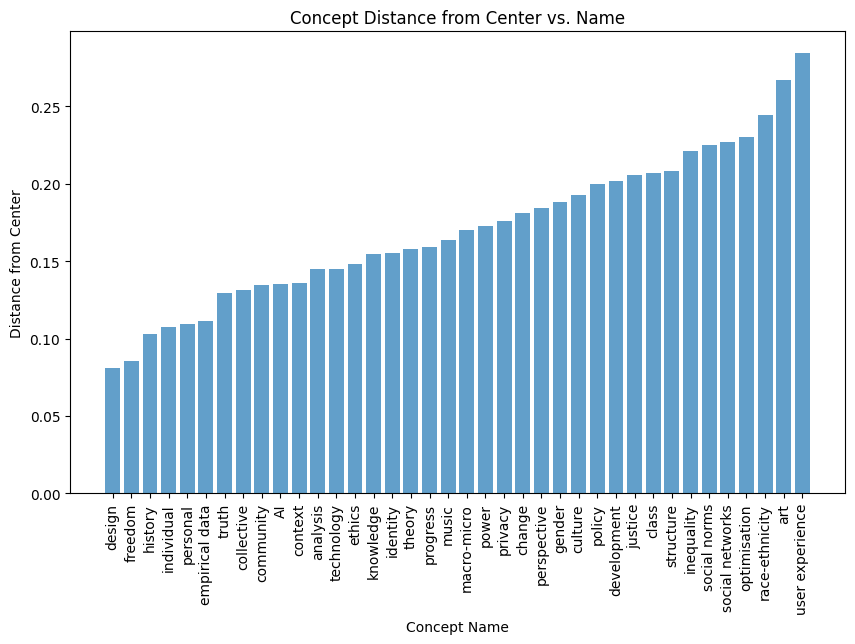

In [ ]:
# plot of name vs. distance_from_center
plt.figure(figsize=(10,6))
merged_df.sort_values('distance_from_center', inplace=True)
plt.bar(merged_df.index, merged_df['distance_from_center'], alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Concept Name')
plt.ylabel('Distance from Center')
plt.title('Concept Distance from Center vs. Name')

### Import edge dataframe

In [ ]:
# read all CSV files matching the given suffix and combine into a single DataFrame

def create_network_df(filename_suffix):
    file_pattern = os.path.join('../data/network_data', filename_suffix)
    csv_files = glob.glob(file_pattern)

    print(f"Found {len(csv_files)} attribute list files")

    # Helper function to read CSV and add session_id
    def read_and_add_session_id(file):
        df = pd.read_csv(file)
        filename = os.path.basename(file)
        session_id = filename.split('_')[1]
        df['session_id'] = session_id
        return df
    
    # Read all CSV files and concatenate using list comprehension
    output_df = pd.concat([read_and_add_session_id(file) for file in csv_files], ignore_index=True)

    print(f"Combined dataframe shape: {output_df.shape}")
    print(output_df.head())

    return output_df

edge_df = create_network_df('*_edgeList_relate.csv')

Found 17 attribute list files
Combined dataframe shape: (231, 8)
   edgeID  from  to                  networkCanvasEgoUUID  \
0       1     1   6  7be8425e-a3ba-4d37-a9c9-14ea20de21cb   
1       2     1   9  7be8425e-a3ba-4d37-a9c9-14ea20de21cb   
2       3     1   8  7be8425e-a3ba-4d37-a9c9-14ea20de21cb   
3       4     1   5  7be8425e-a3ba-4d37-a9c9-14ea20de21cb   
4       5     1   7  7be8425e-a3ba-4d37-a9c9-14ea20de21cb   

                      networkCanvasUUID networkCanvasSourceUUID  \
0  4e297ced-e3ec-4454-9aaf-e8482c0447f7              ZuysvCGddv   
1  d5b357a4-62d4-46a8-a786-4f25c37abf48              ZuysvCGddv   
2  b3225591-d8b4-4d02-936a-a1a2d900cf74              ZuysvCGddv   
3  f75e2aec-bd00-48a2-8218-be4dbe6f926c              ZuysvCGddv   
4  dd985d1e-faf6-4e0e-8375-e0efb477c249              ZuysvCGddv   

  networkCanvasTargetUUID                 session_id  
0              acTsAWfdzn  cmh1u7a3d000bsa27gwe0vmf6  
1              m3bCphZ8J2  cmh1u7a3d000bsa27gwe0vmf6  


In [ ]:
edges_grouped_1 = edge_df.groupby(['session_id', 'to']).size().reset_index(name='n_edges_to')
edges_grouped_2 = edge_df.groupby(['session_id', 'from']).size().reset_index(name='n_edges_from')

df_alters = df_alters.merge(edges_grouped_1[['session_id', 'to', 'n_edges_to']], left_on = ['session_id', 'nodeID'], right_on = ['session_id', 'to'], how = 'left')
df_alters = df_alters.merge(edges_grouped_2[['session_id', 'from', 'n_edges_from']], left_on = ['session_id', 'nodeID'], right_on = ['session_id', 'from'], how = 'left')
df_alters.fillna(0, inplace=True)
df_alters['n_edges'] = df_alters['n_edges_to'] + df_alters['n_edges_from']

In [ ]:
df_alters

,nodeID,networkCanvasEgoUUID_x,networkCanvasUUID,name,user_layout_x,user_layout_y,user_layout_screenSpaceX,user_layout_screenSpaceY,session_id,networkCanvasEgoUUID_y,...,secret_word,in_gcc,distance,angle_rad,nearest_angle_node,to,n_edges_to,from,n_edges_from,n_edges
0,1,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ZuysvCGddv,AI,0.677439,0.639616,1300.68,389.21,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,falafel,1.0,0.225781,0.904131,ethics,0.0,0.0,1.0,3.0,3.0
1,2,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,zfLP4gy4BA,analysis,0.551915,0.381659,1059.68,667.81,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,falafel,1.0,0.129228,2.728188,optimisation,2.0,2.0,2.0,2.0,4.0
2,3,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,kojNKla2jv,context,0.481428,0.731364,924.34,290.13,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,falafel,1.0,0.232108,-0.080101,personal,3.0,2.0,3.0,2.0,4.0
3,4,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,RtJiUdZJi6,empirical data,0.481428,0.489363,924.34,551.49,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,falafel,1.0,0.021403,-2.090946,social networks,4.0,1.0,4.0,3.0,4.0
4,5,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,KaMS6JqOHq,ethics,0.603090,0.515956,1157.93,522.77,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,falafel,1.0,0.104317,1.417236,progress,5.0,3.0,5.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,8,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ndsons1JEx,social networks,0.673568,0.580938,1293.25,452.59,cmh4n1pe9003gsa27d06mabf0,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,cookie,0.0,0.191512,1.134454,community,0.0,0.0,0.0,0.0,0.0
182,9,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,uBiRoP3A3s,progress,0.379092,0.532845,727.86,504.53,cmh4n1pe9003gsa27d06mabf0,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,cookie,0.0,0.125289,-1.305547,knowledge,0.0,0.0,0.0,0.0,0.0
183,10,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,qlYrXp5pWY,power,0.524712,0.682991,1007.45,342.37,cmh4n1pe9003gsa27d06mabf0,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,cookie,1.0,0.184652,0.134235,macro-micro,10.0,1.0,0.0,0.0,1.0
184,11,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,FXe1ucLJSr,perspective,0.434913,0.406158,835.03,641.35,cmh4n1pe9003gsa27d06mabf0,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,cookie,0.0,0.114204,-2.535189,AI,0.0,0.0,0.0,0.0,0.0


### Operationalize "centered" networks vs. "scattered" networks

One thing I noticed looking at the networks was that some have a clear term which is central and well-connected, while others do not. Here I try to do a rough operationalization of centralized networks as ones which have a term that is both the most central and the most connected (with more than 1 connection). This is a super rough definition and definitely not perfect but does an ok job of pulling out some examples to highlight for the presentation. 

In [ ]:
# for each session_id, find the alter with the minimum distance from center
nearest_alter = df_alters.loc[df_alters.groupby('session_id')['distance'].idxmin()]
nearest_alter['is_nearest_alter'] = 1
nearest_alter

,nodeID,networkCanvasEgoUUID_x,networkCanvasUUID,name,user_layout_x,user_layout_y,user_layout_screenSpaceX,user_layout_screenSpaceY,session_id,networkCanvasEgoUUID_y,...,in_gcc,distance,angle_rad,nearest_angle_node,to,n_edges_to,from,n_edges_from,n_edges,is_nearest_alter
70,8,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,8JFsJYcFYb,identity,0.556005,0.420069,1067.53,626.33,cmh1trlci0002sa278d3vv3ip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.097599,2.530415,technology,8.0,3.0,8.0,1.0,4.0,1
73,1,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ZuysvCGddv,AI,0.498878,0.557123,957.85,478.31,cmh1u7a3d000bsa27gwe0vmf6,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.057134,-0.019643,progress,0.0,0.0,1.0,9.0,9.0,1
3,4,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,RtJiUdZJi6,empirical data,0.481428,0.489363,924.34,551.49,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.021403,-2.090946,social networks,4.0,1.0,4.0,3.0,4.0,1
95,1,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ZuysvCGddv,AI,0.477066,0.531753,915.97,505.71,cmh1uot9n000osa27eayyicd9,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.039169,-0.625504,art,0.0,0.0,1.0,1.0,1.0,1
60,10,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,WAhTMmxJoA,knowledge,0.507130,0.457210,973.69,586.21,cmh1w9kqc0011sa27sx6ud8sm,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.043380,2.976489,AI,10.0,2.0,10.0,2.0,4.0,1
110,6,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,RtJiUdZJi6,empirical data,0.505323,0.540811,970.22,495.92,cmh200ziw001hsa27kc2dl64f,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.041157,0.129696,analysis,6.0,6.0,0.0,0.0,6.0,1
164,2,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,RtJiUdZJi6,empirical data,0.547150,0.505469,1050.53,534.09,cmh205bqc001qsa273cbrl5cg,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.047466,1.455328,privacy,0.0,0.0,2.0,1.0,1.0,1
86,4,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,kojNKla2jv,context,0.446587,0.539059,857.45,497.82,cmh20bfbo001vsa27rn1wly2f,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.066170,-0.939396,analysis,4.0,3.0,4.0,2.0,5.0,1
153,3,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,kojNKla2jv,context,0.587985,0.502365,1128.93,537.45,cmh20nti10021sa2781v0n7gr,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.088017,1.543918,theory,3.0,2.0,3.0,2.0,4.0,1
12,3,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,fWLVVobTqz,culture,0.425812,0.504357,817.56,535.29,cmh20p3iy0027sa27jqf9dcog,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.074316,-1.512132,social norms,3.0,2.0,3.0,1.0,3.0,1


In [ ]:
# for each session_id, find the alter with the most edges 
most_edges = df_alters.loc[df_alters.groupby('session_id')['n_edges'].idxmax()]
most_edges['has_most_edges'] = 1
most_edges

,nodeID,networkCanvasEgoUUID_x,networkCanvasUUID,name,user_layout_x,user_layout_y,user_layout_screenSpaceX,user_layout_screenSpaceY,session_id,networkCanvasEgoUUID_y,...,in_gcc,distance,angle_rad,nearest_angle_node,to,n_edges_to,from,n_edges_from,n_edges,has_most_edges
72,10,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,OruxeroRhC,structure,0.572454,0.579737,1099.11,453.88,cmh1trlci0002sa278d3vv3ip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.107738,0.737580,social networks,10.0,4.0,10.0,1.0,5.0,1
73,1,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ZuysvCGddv,AI,0.498878,0.557123,957.85,478.31,cmh1u7a3d000bsa27gwe0vmf6,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.057134,-0.019643,progress,0.0,0.0,1.0,9.0,9.0,1
1,2,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,zfLP4gy4BA,analysis,0.551915,0.381659,1059.68,667.81,cmh1ulurw000lsa2750fqbpip,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.129228,2.728188,optimisation,2.0,2.0,2.0,2.0,4.0,1
95,1,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,ZuysvCGddv,AI,0.477066,0.531753,915.97,505.71,cmh1uot9n000osa27eayyicd9,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.039169,-0.625504,art,0.0,0.0,1.0,1.0,1.0,1
53,3,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,QUTNIZIDgY,change,0.389400,0.365827,747.65,684.91,cmh1w9kqc0011sa27sx6ud8sm,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.173882,-2.452203,ethics,3.0,4.0,3.0,2.0,6.0,1
108,4,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,bihlMPLDwN,community,0.603413,0.593812,1158.55,438.68,cmh200ziw001hsa27kc2dl64f,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.139625,0.834041,analysis,4.0,1.0,4.0,8.0,9.0,1
171,9,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,m3bCphZ8J2,technology,0.511490,0.403388,982.06,644.34,cmh205bqc001qsa273cbrl5cg,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.097293,3.023217,ethics,0.0,0.0,9.0,3.0,3.0,1
86,4,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,kojNKla2jv,context,0.446587,0.539059,857.45,497.82,cmh20bfbo001vsa27rn1wly2f,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.066170,-0.939396,analysis,4.0,3.0,4.0,2.0,5.0,1
157,7,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,xB0NLvIg6i,individual,0.500089,0.392371,960.17,656.24,cmh20nti10021sa2781v0n7gr,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.107629,3.140769,identity,7.0,5.0,0.0,0.0,5.0,1
20,11,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,WAhTMmxJoA,knowledge,0.560389,0.406009,1075.95,641.51,cmh20p3iy0027sa27jqf9dcog,7be8425e-a3ba-4d37-a9c9-14ea20de21cb,...,1.0,0.111719,2.570511,truth,11.0,5.0,0.0,0.0,5.0,1


In [ ]:
df_alters = df_alters.merge(nearest_alter[['session_id', 'name', 'is_nearest_alter']], on = ['session_id', 'name'], how='left')
df_alters = df_alters.merge(most_edges[['session_id', 'n_edges', 'has_most_edges']], on = ['session_id', 'n_edges'], how='left')

In [ ]:
central_dfs = df_alters[(df_alters['is_nearest_alter'] == 1) & (df_alters['has_most_edges'] == 1) & (df_alters['n_edges'] > 1)][['name', 'secret_word', 'n_edges', 'distance']]
central_dfs

,name,secret_word,n_edges,distance
3,empirical data,falafel,4.0,0.021403
34,technology,cats,4.0,0.021425
45,AI,random,4.0,0.008563
73,AI,Dolphin,9.0,0.057134
86,context,triceratops,5.0,0.066170
117,AI,peanuts,4.0,0.026506
143,ethics,cat,5.0,0.032142


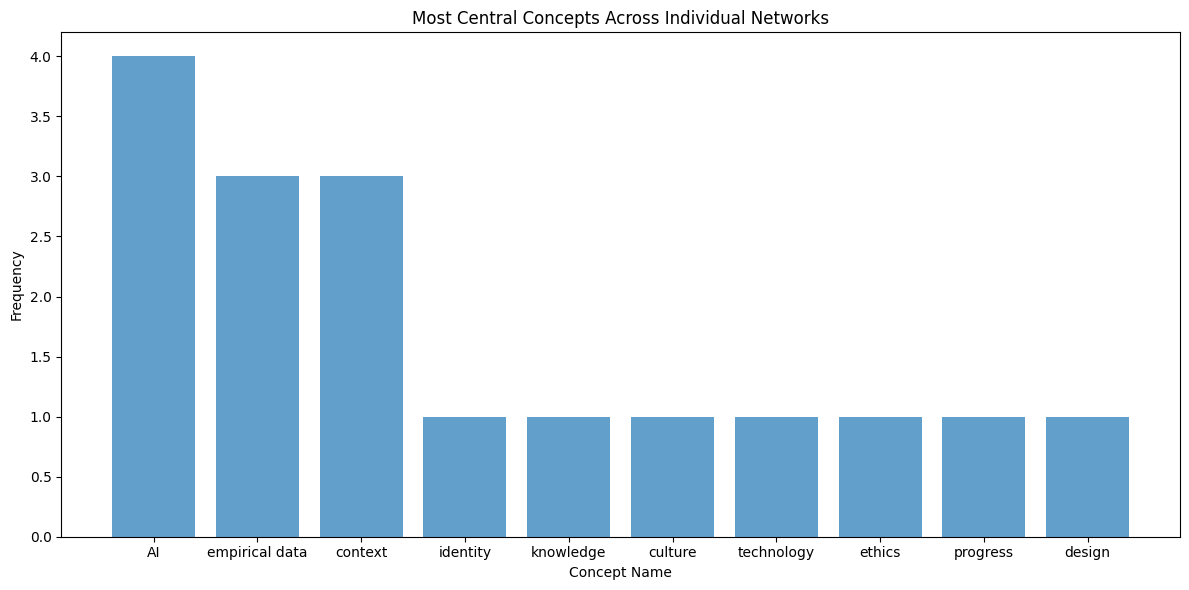

In [ ]:
# Count the frequency of each concept in nearest_alter and sort
name_counts = nearest_alter['name'].value_counts()

# Create histogramc
plt.figure(figsize=(12, 6))
plt.bar(range(len(name_counts)), name_counts.values, alpha=0.7)
plt.xticks(range(len(name_counts)), name_counts.index)
plt.xlabel('Concept Name')
plt.ylabel('Frequency')
plt.title('Most Central Concepts Across Individual Networks')
plt.tight_layout()
plt.show()